In [ ]:
# ====================================================
# Phase 1: Data Preparation
# Project: Predictive Analytics for Supply Chain Optimization
# ====================================================

# --- 1/1. Import Required Libraries ---
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)


In [ ]:
# --- 1/2. Import data ---
try:
  df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\dynamic_supply_chain_logistics_dataset.csv", encoding='utf-8')
  cities_df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\uscities.csv")
except UnicodeDecodeError:
  df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\dynamic_supply_chain_logistics_dataset.csv", encoding='latin-1')
  cities_df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\uscities.csv")
print("Dataset loaded successfully!")


# Preview
# df.head()
# df_city.head()


# Show list of columns
# print(df_city.columns)

In [ ]:
# --- 1/3. Basic Data Overview ---

print("Shape of dataset:", df.shape)
# print("\nColumns:\n", df.columns.tolist())
print("\nMissing values summary:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

In [ ]:
# --- 1/4. Timestamp for testing ---
# Choose range and count
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2024-12-31")

# Replace timestamp column with random dates
df['timestamp'] = pd.to_datetime(
    np.random.randint(
        start_date.value // 10**9,
        end_date.value // 10**9,
        len(df)
    ),
    unit='s'
)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# print(df.head())

In [ ]:
# --- 1/5. Handle Missing Values with NumPy ---
# Identify numeric columns, but exclude 'timestamp'
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != 'timestamp']

# Identify categorical columns
# cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Impute numeric columns with median
for col in num_cols:
    median_val = np.nanmedian(df[col])
    df[col] = df[col].fillna(median_val)

# If 'timestamp' is datetime and has missing values, optionally impute separately
if df['timestamp'].isna().any():
    # Replace NaT with some default, e.g., first date
    df['timestamp'] = df['timestamp'].fillna(df['timestamp'].min())


# print(df['timestamp'].head())


In [ ]:
# --- 1/6. Narrow search field ---

# Keep only rows where vehicle_gps_latitude >= 35
df = df[df['vehicle_gps_latitude'] >= 35]
df = df[df['vehicle_gps_longitude'] >= -110]
df = df[df['vehicle_gps_longitude'] <= -85]

In [ ]:
# --- 1/7 Nearest City Assignment Using KDTree ---
from scipy.spatial import cKDTree
import numpy as np
from geopy.distance import geodesic

# Example: your cities DataFrame
# cities = pd.read_csv("uscities.csv")
# Keep only necessary columns
cities = cities_df[['city', 'state_id', 'lat', 'lng']]

# Build KDTree
city_coords = cities_df[['lat', 'lng']].values
tree = cKDTree(city_coords)

# Vehicle coordinates
vehicle_coords = df[['vehicle_gps_latitude', 'vehicle_gps_longitude']].values

# Query nearest city (k=1 for nearest)
distances, idx = tree.query(vehicle_coords, k=1)

# Optional: compute approximate distance in km (using Haversine)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of earth in km
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Compute distances for all rows
vehicle_lat = df['vehicle_gps_latitude'].values
vehicle_lon = df['vehicle_gps_longitude'].values
city_lat = cities_df.iloc[idx]['lat'].values
city_lon = cities_df.iloc[idx]['lng'].values

dist_km = haversine(vehicle_lat, vehicle_lon, city_lat, city_lon)

# Set threshold, e.g., 50 km
threshold_km = 50

# Assign vehicle_city only if within threshold
# Pre-build city + state
cities_df["city_full"] = cities_df["city"].astype(str) + ", " + cities_df["state_id"].astype(str)

# Assign nearest city only when it is within threshold
df["vehicle_city"] = np.where(
    dist_km <= threshold_km,
    cities_df.iloc[idx]["city_full"].values,
    np.nan
)
# Remove rows with any NaN values
# df_clean = df.dropna()
df = df.dropna()

# Check the result
# print(df_clean.shape)  # number of rows and columns after dropping
# print(df['vehicle_city'])


In [ ]:
# 1/8 Add a unique ID for each row
df['row_id'] = range(1, len(df) + 1)

# Check
# print(df[['row_id', 'vehicle_gps_latitude', 'vehicle_gps_longitude']].head())


In [ ]:
# --- 1/9 Feature Engineering ---

## 5.1 Create derived features
# Example: combine GPS into one column
df['vehicle_location'] = df['vehicle_gps_latitude'].astype(str) + ',' + df['vehicle_gps_longitude'].astype(str)

# Example: compute delay difference in minutes
df['eta_variation_minutes'] = df['eta_variation_hours'] * 60

# Example: categorize traffic level
df['traffic_category'] = pd.cut(
    df['traffic_congestion_level'],
    bins=[0, 3, 6, 10],
    labels=['Low', 'Medium', 'High']
)

# Example: flag if weather severity exceeds threshold
df['severe_weather_flag'] = np.where(df['weather_condition_severity'] > 0.7, 1, 0)

# ===========================================================
print("\n Feature engineering complete. New columns added:", 
      [c for c in df.columns if 'vehicle_location' in c or 'eta_variation_minutes' in c or 'traffic_category' in c or 'severe_weather_flag' in c])

In [ ]:
# --- 1/10. Clustering ---
from sklearn.cluster import KMeans
import numpy as np

# --- Temporal features ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['eta_minus_actual_hours'] = df['eta_variation_hours'] - df['delivery_time_deviation']
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df = df.sort_values(['row_id', 'timestamp'])

df['avg_route_congestion'] = (
    df.groupby('route_risk_level')['traffic_congestion_level']
      .transform(lambda x: x.rolling(5).mean())
)

# --- Clustering ---
coords = df[['vehicle_gps_latitude', 'vehicle_gps_longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['route_cluster'] = kmeans.fit_predict(coords)

# --- Cluster statistics ---
cluster_stats = (
    df.groupby('route_cluster')
      .agg(
          avg_delay=('delivery_time_deviation', 'mean'),
          avg_risk=('route_risk_level', 'mean'),
          avg_congestion=('traffic_congestion_level', 'mean'),
          lat=('vehicle_gps_latitude', 'mean'),
          lon=('vehicle_gps_longitude', 'mean')
      )
      .reset_index()
)

# Determine geographic labels
lat_median = cluster_stats['lat'].median()
lon_median = cluster_stats['lon'].median()

def geo_label(row):
    parts = []
    # North / South
    parts.append("Northern" if row['lat'] > lat_median else "Southern")
    # East / West
    parts.append("Eastern" if row['lon'] > lon_median else "Western")
    return " ".join(parts)

cluster_stats['geo'] = cluster_stats.apply(geo_label, axis=1)

# Categorize delay
def delay_label(v):
    return "High-delay" if v > cluster_stats['avg_delay'].median() else "Stable-delivery"

# Categorize risk
def risk_label(v):
    return "High-risk" if v > cluster_stats['avg_risk'].median() else "Low-risk"

# Congestion
def congestion_label(v):
    return "Congested" if v > cluster_stats['avg_congestion'].median() else "Free-flow"

cluster_stats['delay_text'] = cluster_stats['avg_delay'].apply(delay_label)
cluster_stats['risk_text'] = cluster_stats['avg_risk'].apply(risk_label)
cluster_stats['cong_text'] = cluster_stats['avg_congestion'].apply(congestion_label)

# FINAL NAME
cluster_stats['cluster_name'] = (
    cluster_stats['geo'] + " — " +
    cluster_stats['delay_text'] + ", " +
    cluster_stats['risk_text'] + ", " +
    cluster_stats['cong_text']
)

# Map into df
name_map = cluster_stats.set_index('route_cluster')['cluster_name'].to_dict()
df['cluster_desc'] = df['route_cluster'].map(name_map)

cluster_stats


In [ ]:
# --- 1/11. Categorical columns ---
# Identify which columns are categorical
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# cat_cols = df.select_dtypes(exclude=np.number).columns
print("Categorical columns:", list(cat_cols))


In [ ]:
# --- 1/12. Categorical columns ---
# Categorical columns → replace NaN with most frequent value (mode)
for col in cat_cols:
    mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
    df[col] = df[col].fillna(mode_val)

print("\n Missing values handled with NumPy (median/mode).")


In [ ]:
# --- 1/13. Save Cleaned Dataset ---
df.to_csv('cleaned_logistics_data.csv', index=False)
print("\n Cleaned dataset saved as 'cleaned_logistics_data.csv'.")


In [ ]:
# --- 1-14. Remove Duplicates ---
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"\n Removed {initial_shape[0] - df.shape[0]} duplicate rows.")

In [ ]:
# --- 1/18. Final Dataset Summary ---
print("\nFinal dataset shape:", df.shape)
print("\nSample data:")
display(df.head())
# print(df.shipping_costs)

In [ ]:
# ====================================================
# Phase 2: Exploratory Data Analysis (EDA)
# ====================================================

# --- 2/1. Import Required Libraries ---

import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", context="notebook")

# Assume df is already loaded and cleaned from Phase 1
print(" DataFrame available with shape:", df.shape)

In [ ]:
# --- 2/2. Route clusters ---
# Ensure necessary columns exist
required_cols = [
    'vehicle_gps_latitude',
    'vehicle_gps_longitude',
    'route_cluster',
    'delivery_time_deviation'
]

for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

# Plot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df,
    x='vehicle_gps_longitude',
    y='vehicle_gps_latitude',
    hue='cluster_desc',      # ✔ Человеческие описания в легенде
    size='delivery_time_deviation',
    palette='tab10',
    sizes=(40, 300),
    alpha=0.8,
    legend="brief"
)

plt.title("Route Clusters Based on GPS Coordinates\n(Bubble Size = Delivery Time Deviation)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()


In [ ]:
# --- 2/3. Prepare stat data ---
# Define the feature columns (independent variables)
features = [
    "fuel_consumption_rate", "traffic_congestion_level", "weather_condition_severity",
    "warehouse_inventory_level", "loading_unloading_time", "handling_equipment_availability",
    'route_cluster', "port_congestion_level", "shipping_costs", "supplier_reliability_score", ""
    "lead_time_days", "route_risk_level", "driver_behavior_score", "fatigue_monitoring_score"
]

# Define the target column (dependent variable)
# ===============================================
target = "delivery_time_deviation"
# ===============================================

# Keep only the selected columns and remove rows with missing data
stat_df = df[features + [target]].dropna()

# Check the dataset after cleaning
print(f"Data after filtering: {stat_df.shape[0]:,} rows and {stat_df.shape[1]} columns")

# Display summary statistics of the cleaned dataset
stat_df.describe().T


In [ ]:
# --- 2/4. Encode categorical values ---

# Exclude 'vehicle_city' from categorical encoding
cat_cols_to_encode = [col for col in cat_cols if col != 'vehicle_city']

label_enc = LabelEncoder()
for col in cat_cols_to_encode:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# Check result
print(df[cat_cols_to_encode].head())
print("\nCategorical encoding complete.")


In [ ]:
# --- 2/5. Data Correlation ---
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# Assume stat_df has the same feature and target columns
# -----------------------------
# 1️ Spearman correlation (monotonic relationships)
spearman_corr = stat_df.corr(method='spearman')[target].drop(target).sort_values(ascending=False)
# ================================================================================================


plt.figure(figsize=(8,5))
sns.barplot(x=spearman_corr.values, y=spearman_corr.index, hue=spearman_corr.index, dodge=False, palette="viridis", legend=False)
plt.title("Spearman Correlation with Delivery Time Deviation (stat_df)")
plt.xlabel("Spearman Correlation")
plt.ylabel("Feature")
plt.show()

# -----------------------------
# 2️ Mutual Information (non-linear dependencies)
X_stat = stat_df[features]
y_stat = stat_df[target]
mi = mutual_info_regression(X_stat, y_stat, random_state=42)
mi_series = pd.Series(mi, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    x=mi_series.values, 
    y=mi_series.index, 
    dodge=False, palette="viridis", legend=False
)
plt.title("Mutual Information with Delivery Time Deviation (stat_df)")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.show()

# -----------------------------
# 3️ Feature importance using Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_stat, y_stat)
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=rf_importances.values, y=rf_importances.index, hue=spearman_corr.index, dodge=False, palette="magma", legend=False)
# sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="magma")
plt.title("Random Forest Feature Importance (stat_df)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



In [ ]:
spearman_corr_df = spearman_corr.reset_index()
spearman_corr_df.columns = ['feature', 'spearman_correlation']

print(spearman_corr_df)


In [ ]:
# ====================================================
# 3️ DISTRIBUTION ANALYSIS AND ANOMALY DETECTION
# ====================================================
# --- 3/1. Plot distribution of key numeric variables---

key_vars = [
    'delivery_time_deviation',
    'fuel_consumption_rate',
    'traffic_congestion_level',
    'shipping_costs',
    'lead_time_days',
    'route_cluster'
]
key_vars = [v for v in key_vars if v in df.columns]

for col in key_vars:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
# --- 3/2. Detect anomalies using IQR method for each key numeric column---

def detect_outliers_iqr(series):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

outlier_summary = {col: detect_outliers_iqr(df[col]) for col in key_vars}
print("\n Outlier count per key variable:")
print(pd.Series(outlier_summary))

In [ ]:
# ====================================================
# 4️ SEASONAL & REGIONAL DELAY TRENDS
# ====================================================
# --- 4/1. fuel consumption rate by month---

#correlation between fuel consuntion rate and temperature inside


# Convert timestamp to datetime if needed
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Extract time-based features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()

# --- 4.1 Seasonal trends (monthly average delay)
if 'delivery_time_deviation' in df.columns:
    monthly_delay = df.groupby('month')['delivery_time_deviation'].mean()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=monthly_delay.index, y=monthly_delay.values, marker='o')
    plt.title(" Average Delivery Time Deviation by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg Delivery Deviation")
    plt.show()

In [ ]:
# --- 4.2 Regional trends (by city or location if available)

if 'vehicle_city' in df.columns:
    regional_delay = df.groupby('vehicle_city')['delivery_time_deviation'].mean().sort_values(ascending=False).head(10)
    # regional_delay = df.groupby('vehicle_city')['delivery_time_deviation'].mean().sort_values(ascending=True).head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(
    x=regional_delay.values,
    y=regional_delay.index,
    hue=regional_delay.values,  # use values to color bars
    palette='coolwarm',
    legend=False               # hide legend
    )
    # plt.xticks(rotation=45, ha='right')  # 45 degrees, align right
    plt.title(" Top 10 Cities by Average Delivery Deviation")
    plt.xlabel("Average Delay")
    plt.ylabel("City")
    plt.show()
else:
    print("\n No 'vehicle_city' column found for regional analysis. Skipping.")

In [43]:

# --- 4.2 Regional trends (table)
# Group by city and calculate average delivery delay
regional_delay = (
    df.groupby('vehicle_city')['delivery_time_deviation']
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

# Convert to DataFrame
regional_delay_df = regional_delay.reset_index()
regional_delay_df.columns = ['City', 'Avg_Delivery_Time_Deviation']

# Round the values for better readability
regional_delay_df['Avg_Delivery_Time_Deviation'] = regional_delay_df['Avg_Delivery_Time_Deviation'].round(2)

# Display table
regional_delay_df


,City,Avg_Delivery_Time_Deviation
0,"Hominy, OK",10.0
1,"McNab, AR",10.0
2,"Culver, KS",10.0
3,"Marianna, AR",10.0
4,"Orangeville, UT",10.0
5,"Jamestown, ND",10.0
6,"Greenwich, OH",10.0
7,"Crookston, MN",10.0
8,"Summer Set, MO",10.0
9,"Elgin, PA",10.0


C:\Users\BOB\AppData\Local\Temp\ipykernel_7196\337226240.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_delay = df.groupby('weekday')['delivery_time_deviation'].mean().sort_index()


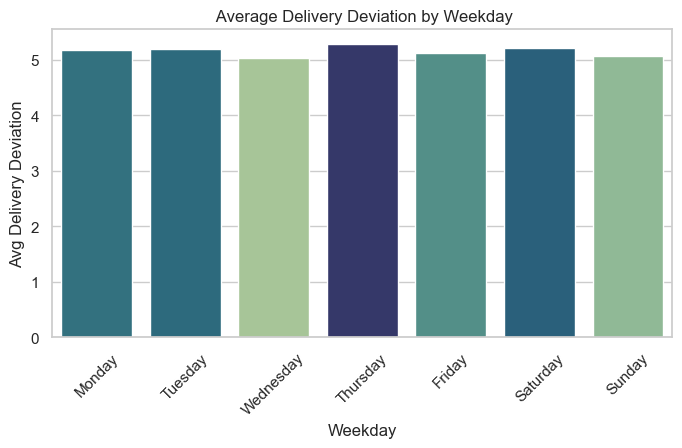


 Phase 2: EDA completed successfully.


In [44]:
# --- 4.3 Weekday delay trends

if 'delivery_time_deviation' in df.columns:
# Define correct order
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Convert to categorical with order
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

    # Group and sort
    weekday_delay = df.groupby('weekday')['delivery_time_deviation'].mean().sort_index()
    # print(weekday_delay)

    # weekday_delay = df.groupby('weekday')['delivery_time_deviation'].mean()
    plt.figure(figsize=(8, 4))
    
    sns.barplot(
    x=weekday_delay.index,
    y=weekday_delay.values,
    hue=weekday_delay.values,  # use values to color bars
    palette='crest',
    legend=False               # hide legend
    )

    plt.title(" Average Delivery Deviation by Weekday")
    plt.xlabel("Weekday")
    plt.ylabel("Avg Delivery Deviation")
    plt.xticks(rotation=45)
    plt.show()

print("\n Phase 2: EDA completed successfully.")


In [ ]:
# --- 4.3 Scale Numerical Features ---
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("\n Numerical features scaled.")

In [ ]:
# ====================================================
# Phase 5: Machine Learning Modeling
# ====================================================
# 5/1 FEATURE SELECTION & ENCODING

# Drop non-numeric / irrelevant columns
exclude_cols = ['timestamp', 'Customer City', 'Customer Email', 'Customer Fname', 'Customer Lname']
df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors='ignore')

# Encode categorical variables
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Replace remaining NaNs with median
df = df.fillna(df.median(numeric_only=True))



In [ ]:
# --- 5.1 DATA CLEANUP BEFORE MODELING


# Work on a copy to preserve df
data = df.copy()

# Drop identifier or irrelevant columns if they exist
drop_cols = [
    'timestamp', 'Customer City', 'Customer Email',
    'Customer Fname', 'Customer Lname'
]
data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')

# --- 1. Convert booleans to int
bool_cols = data.select_dtypes(include=['bool']).columns
if len(bool_cols):
    data[bool_cols] = data[bool_cols].astype(int)

# --- 2. Encode categoricals (object / category)
cat_cols = data.select_dtypes(include=['object', 'category']).columns
if len(cat_cols):
    print("Encoding categorical columns:", list(cat_cols))
    for col in cat_cols:
        data[col] = data[col].astype(str).astype('category').cat.codes

# --- 3. Replace any infinite or missing values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.median(numeric_only=True))

# --- 4. Enforce numeric dtype globally
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- 5. Verify everything is numeric
non_numeric = data.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(" Still non-numeric columns:", non_numeric)
else:
    print(" All columns successfully converted to numeric.")

#  Ready for modeling
df = data


In [ ]:
# --- 5/2: Model Training with Progress Bar ---

#!pip install tqdm --quiet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from tqdm.notebook import tqdm  # progress bar for Jupyter

# --- Example target columns ---
target_reg = "delivery_time_deviation"
target_cls = "risk_classification"

# --- Ensure numeric features only ---
X = df.select_dtypes(include=[np.number])
y_reg = df[target_reg]
y_cls = df[target_cls].astype(str)  # ensure string for classification

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# --- Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Models ---
models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    )
}

# --- Results dict ---
results_reg = {}

# --- Model training with progress bar ---
print(" Training regression models...")
for name in tqdm(models_reg.keys(), desc="Training Progress", leave=False):
    model = models_reg[name]
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    results_reg[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"\n {name} done.")
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

# --- Display summary ---
results_reg_df = pd.DataFrame(results_reg).T
display(results_reg_df.style.background_gradient(cmap="Blues").format("{:.3f}"))


In [ ]:
# --- 5/2: Global storage for trained models---
trained_models = {
    "regression": {},
    "classification": {}
}

In [ ]:
# --- 5/3: Machine Learning Modeling (Optimized)---
\
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# --- 1️ Preprocessing: ensure numeric ---
df_ml = df.copy()

# Drop identifier columns
drop_cols = ['timestamp', 'Customer City', 'Customer Email', 'Customer Fname', 'Customer Lname']
df_ml = df_ml.drop(columns=[c for c in drop_cols if c in df_ml.columns], errors='ignore')

# Encode booleans
bool_cols = df_ml.select_dtypes(include='bool').columns
df_ml[bool_cols] = df_ml[bool_cols].astype(int)

# Encode categorical columns
cat_cols = df_ml.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_ml[col] = LabelEncoder().fit_transform(df_ml[col].astype(str))

# Fill NaNs
df_ml = df_ml.fillna(df_ml.median(numeric_only=True))

print(" Preprocessing complete. Data ready for modeling.")

# --- 2️ Regression: delivery_time_deviation ---
if 'delivery_time_deviation' in df_ml.columns:
    print("\n Regression: delivery_time_deviation")

    X_reg = df_ml.drop(columns=['delivery_time_deviation'])
    y_reg = df_ml['delivery_time_deviation']

    # --- Optional: sample for speed ---
    sample_size = 5000
    if len(X_reg) > sample_size:
        X_reg = X_reg.sample(sample_size, random_state=42)
        y_reg = y_reg.loc[X_reg.index]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models
    models_reg = {
        "Linear Regression": LinearRegression(),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    }

    results_reg = {}
    for name in tqdm(models_reg.keys(), desc="Regression Models", leave=False):
        model = models_reg[name]
        start = pd.Timestamp.now()
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        elapsed = (pd.Timestamp.now() - start).total_seconds()

        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        results_reg[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
        print(f"\n {name} done in {elapsed:.2f} sec | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

        # Feature importance for Random Forest
        if hasattr(model, 'feature_importances_'):
            feat_imp = pd.Series(model.feature_importances_, index=X_reg.columns)
            feat_imp.nlargest(10).plot(kind='barh', figsize=(8,4), title=f"Top 10 Feature Importances ({name})")
            plt.show()

# --- 3️ Classification: risk_classification & delay_probability ---
def run_classification(target_col):
    print(f"\n Classification: {target_col}")
    if target_col not in df_ml.columns:
        print(f" Column '{target_col}' not found. Skipping.")
        return

    X = df_ml.drop(columns=[target_col])
    y = df_ml[target_col]

    # Optional sampling
    sample_size = 5000
    if len(X) > sample_size:
        X = X.sample(sample_size, random_state=42)
        y = y.loc[X.index]

    # Encode target
    y = LabelEncoder().fit_transform(y.astype(str))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models
    models_cls = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest Classifier": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    }

    for name in tqdm(models_cls.keys(), desc=f"{target_col} Models", leave=False):
        model = models_cls[name]
        start = pd.Timestamp.now()
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        # --- Save trained model globally ---
        trained_models['classification'][f"{target}_{name}"] = model
        elapsed = (pd.Timestamp.now() - start).total_seconds()

        acc = accuracy_score(y_test, preds)
        print(f"\n {name} done in {elapsed:.2f} sec | Accuracy: {acc:.3f}")

# Run classification tasks
for target in ['risk_classification', 'delay_probability']:
    run_classification(target)

print("\n Phase 3: Machine Learning Modeling completed successfully.")


In [ ]:
# ====================================================
# Phase 6: Insights & Recommendations
# ====================================================


print(" Phase 4: Interpreting model outputs and generating recommendations")

# --- 1️ Regression Insights: delivery_time_deviation ---
if 'delivery_time_deviation' in df_ml.columns:
    print("\n🔹 Regression Insights: Top drivers of delivery time deviation")

    # Use the last trained Random Forest model from Phase 3
    rf_model = models_reg.get("Random Forest Regressor", None)

    if rf_model is not None:
        # Feature importance
        feat_imp = pd.Series(rf_model.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
        top_features = feat_imp.head(10)
        print("\nTop 10 features driving delivery time deviation:")
        display(top_features)

        # Visualize
        # sns.barplot(
        #     x=top_features.values,
        #     y=top_features.index,
        #     hue=top_features.index,     # color by the same variable
        #     palette="viridis",
        #     dodge=False,
        #     legend=False
        # )
        plt.figure(figsize=(8,5))
        sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
        plt.title("Top 10 Feature Importances — Delivery Time Deviation")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

        # Recommendations
        print("\n Recommendations based on top features:")
        for feat in top_features.index:
            print(f"- Monitor and optimize {feat} to reduce delivery time deviations.")


In [ ]:
# --- 6/2. Classification Insights ---
for target in ['risk_classification', 'delay_probability']:
    print(f"\n🔹 Classification Insights: {target}")

    # Access the trained Random Forest Classifier from the global dictionary
    rf_model_cls = trained_models['classification'].get(f"{target}_Random Forest Classifier", None)

    if rf_model_cls is not None:
        # Ensure we use the same features as in training
        X_train_cls = df_ml.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')

        # Feature importance
        feat_imp_cls = pd.Series(rf_model_cls.feature_importances_, index=X_train_cls.columns).sort_values(ascending=False)
        top_features_cls = feat_imp_cls.head(10)

        print("\nTop 10 features driving classification outcome:")
        display(top_features_cls)


        
        plt.figure(figsize=(8,5))
        sns.barplot(x=top_features_cls.values, y=top_features_cls.index, palette="magma")
        plt.title(f"Top 10 Feature Importances — {target}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

        # Recommendations
        print("\n Recommendations based on top features:")
        for feat in top_features_cls.index:
            print(f"- Investigate and improve {feat} to reduce {target.replace('_',' ')} risks.")
    else:
        print(f" No trained model found for {target}, skipping.")
